In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch
import glob


In [2]:
root_dir = "/scratch/scratch6/akansh12/Parse_data/train/train/"
train_images = sorted(glob.glob(os.path.join(root_dir, "*", 'image', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, "*", 'label', "*.nii.gz")))

data_dicts = [{"image": images_name, "label": label_name} for images_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-700,
            a_max=300,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-700, a_max=300, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [4]:
# train_ds = CacheDataset(
#     data=train_files,
#     transform=train_transforms,
#     cache_num=24,
#     cache_rate=1.0,
#     num_workers=8,
# )
# train_loader = DataLoader(
#     train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
# )
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  4.10s/it]


image shape: torch.Size([1, 256, 224, 176]), label shape: torch.Size([1, 256, 224, 176])


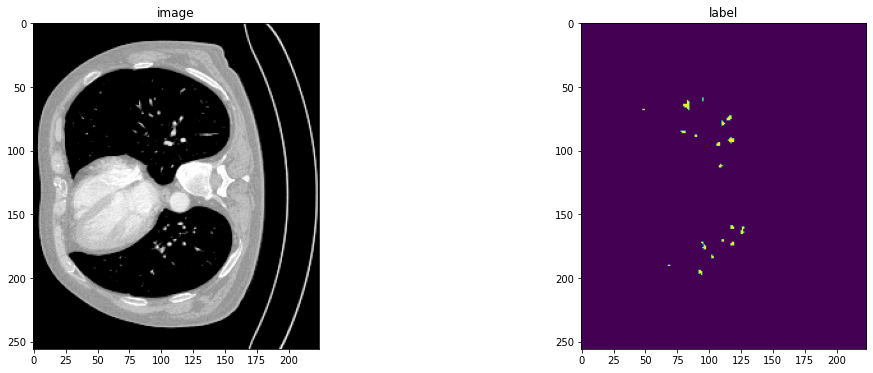

In [5]:
slice_map = {
    "PA000303.nii.gz": 70
    ,
}

case_num = 0
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Model

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "/scratch/scratch6/akansh12/challenges/parse2022/temp/best_metric_model_Unettr.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [ ]:
max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=2)
post_pred = AsDiscrete(argmax=True, to_onehot=2)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "/scratch/scratch6/akansh12/challenges/parse2022/temp/best_metric_model_Unettr.pth")))

In [48]:
len(model.state_dict().keys())

170

### Evaluation Code

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


In [6]:
root_dir = "/scratch/scratch6/akansh12/Parse_data/train/train/"
train_images = sorted(glob.glob(os.path.join(root_dir, "*", 'image', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, "*", 'label', "*.nii.gz")))

data_dicts = [{"image": images_name, "label": label_name} for images_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  4.09s/it]


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

In [18]:
path2model = "/scratch/scratch6/akansh12/challenges/parse2022/temp/best_metric_model_Unettr_rbcdsai.pth"
state_dict = torch.load(path2model, map_location='cpu')
for keyA, keyB in zip(state_dict, model.state_dict()):
    state_dict = OrderedDict((keyB if k == keyA else k, v) for k, v in state_dict.items())
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
metric_dice = np.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/metric_values_rbcdsai_unetTr.npy")
epoch_loss = np.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/epoch_loss_rbcdsai_unetTr.npy")

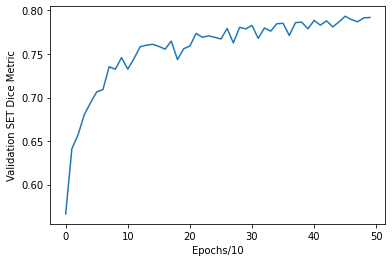

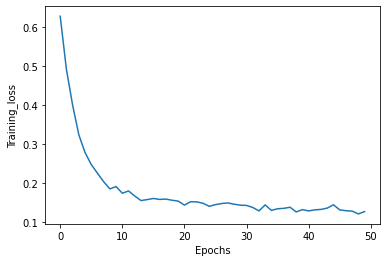

In [11]:
plt.plot(metric_dice)
plt.xlabel("Epochs/10")
plt.ylabel("Validation SET Dice Metric")
plt.show()
plt.plot(epoch_loss)
plt.xlabel("Epochs")
plt.ylabel("Training_loss")
plt.show()

In [ ]:
case_num = 4
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cpu()
    val_labels = torch.unsqueeze(label, 1).cpu()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )

val_outputs = torch.argmax(val_outputs, dim=1)

Text(0.5, 1.0, 'Overlap')

<Figure size 1440x1440 with 0 Axes>

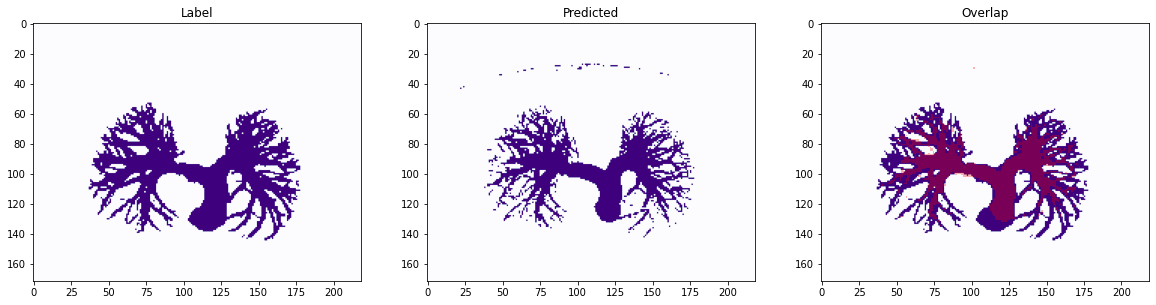

<Figure size 1440x1440 with 0 Axes>

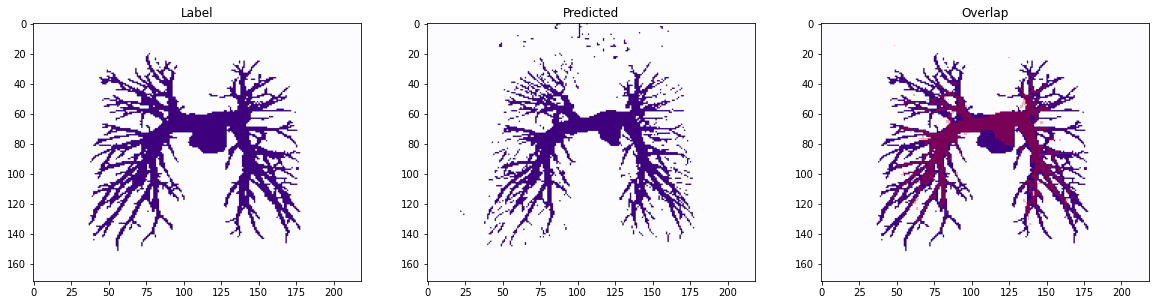

<Figure size 1440x1440 with 0 Axes>

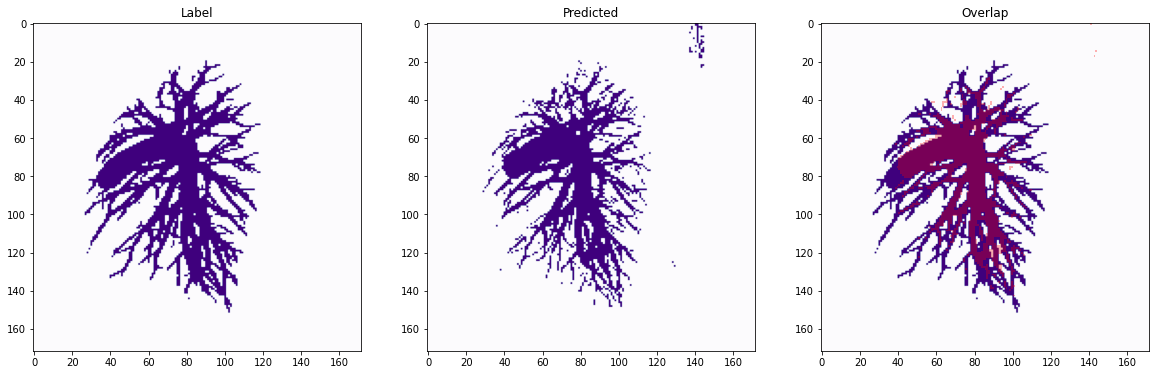

In [62]:

plt.figure(figsize=(20,20))
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(val_labels[0][0].sum(axis = 2)>0), cmap = 'Purples')
plt.title("Label")
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(val_outputs[0].sum(axis = 2)>0), cmap = 'Purples');
plt.title("Predicted")
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(val_labels[0][0].sum(axis = 2)>0), cmap = 'Purples')
mask_ = np.ma.masked_where((val_outputs[0].sum(axis = 2) >0) == 0, val_outputs[0].sum(axis = 2)>0)
plt.imshow(np.rot90(mask_), alpha=0.3, cmap = "autumn")
plt.title("Overlap")

plt.figure(figsize=(20,20))
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(val_labels[0][0].sum(axis = 1)>0), cmap = 'Purples')
plt.title("Label")
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(val_outputs[0].sum(axis = 1)>0), cmap = 'Purples');
plt.title("Predicted")
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(val_labels[0][0].sum(axis = 1)>0), cmap = 'Purples')
mask_ = np.ma.masked_where((val_outputs[0].sum(axis = 1) >0) == 0, val_outputs[0].sum(axis = 1)>0)
plt.imshow(np.rot90(mask_), alpha=0.3, cmap = "autumn")
plt.title("Overlap")


plt.figure(figsize=(20,20))
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(val_labels[0][0].sum(axis = 0)>0), cmap = 'Purples')
plt.title("Label")
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(val_outputs[0].sum(axis = 0)>0), cmap = 'Purples');
plt.title("Predicted")
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(val_labels[0][0].sum(axis = 0)>0), cmap = 'Purples')
mask_ = np.ma.masked_where((val_outputs[0].sum(axis = 0) >0) == 0, val_outputs[0].sum(axis = 0)>0)
plt.imshow(np.rot90(mask_), alpha=0.3, cmap = "autumn")
plt.title("Overlap")
